In [1]:
import os
import pandas as pd
import numpy as np
import mne
import sys
import random
import glob
import torch
import matplotlib.pyplot as plt
from pymatreader import read_mat
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# from lightgbm import LGBMClassifier
import optuna.integration.lightgbm as lgb
from feature_extractor import EEGCSVreader, EEGFeatureExtractor
import warnings
%matplotlib widget
warnings.simplefilter('ignore', FutureWarning)

## サンプルデータを覗く

### データ読み込み

In [ ]:
# データからオブジェクト生成
def make_mne_data(data):
    # MNEのチャンネル情報のを読み込む
    ch_names = [c.replace(' ', '') for c in data['ch_labels']]  # チャンネル名を取得
    ch_types = ['eeg'] * len(ch_names)  # チャンネルタイプ（全てEEGと仮定）

    # チャンネル情報を組み立てる
    info = mne.create_info(ch_names=ch_names, sfreq=500, ch_types=ch_types) # type: ignore

    # データからRawArrayオブジェクトの作成
    raw = mne.io.RawArray(data['data']*1e-6, info) # Vに変換
    raw.set_montage(mne.channels.make_standard_montage('standard_1020'))

    return raw

front_epochs = []
back_epochs = []
pump_epochs = []
reverse_pump_epochs = []

for i in [1,2,3]:
    # サンプルデータの読み込み
    data = read_mat(os.path.join('.', 'train', 'subject3', f'train{i}.mat'))
    raw = make_mne_data(data)
    # raw.plot(start=109.5,duration=1, n_channels=72)   # 生波形をプロット
    # raw.plot_psd(fmax=100)  # パワースペクトル密度をプロット

    # # ICA
    # ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
    # ica.fit(raw)
    # # ica.plot_components()
    # ica.plot_properties(raw, picks=[0,1], psd_args={'fmax': 35.}, image_args={'sigma': 1.})

    # イベントの読み込み
    events = pd.DataFrame(data['event']).astype({'type': int, 'init_index':int}) # type: ignore
    events['type'] = events['type'] % 10    # led と laserを区別しない→typeの下一桁を採用
    # typeで3が連続している時，後半の3を4にしたい(逆足パンピング)
    idx = events[events['type']==3].index
    idx = idx[1::2]
    events.loc[idx, 'type'] = 4
    events['init_time'] = (events['init_time']*500).astype(int) # 2ms間隔のインデックスに変換
    events = events.rename(columns={'init_time': 'id', 'init_index':'test', 'type':'event_id'})[['id', 'test', 'event_id']]
    event_dict = {
        'frontside_kickturn': 1,
        'backside_kickturn': 2,
        'pumping': 3,
        'reverse_pumping': 4
    } 
    print(events.head())

    # create epoch
    reject_criteria = dict(eeg=100e-6)  # 100uV
    epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=0.2, tmax=0.7, baseline=None, reject=reject_criteria, preload=True)
    # epochs.plot(n_epochs=5, n_channels=72)

    epochs.equalize_event_counts(event_dict.keys())  # イベント数を均等にする
    # count how many
    front_epochs.append(epochs['frontside_kickturn'])
    back_epochs.append(epochs['backside_kickturn'])
    pump_epochs.append(epochs['pumping'])
    reverse_pump_epochs.append(epochs['reverse_pumping'])
    del epochs

front_epochs = mne.concatenate_epochs(front_epochs)
back_epochs = mne.concatenate_epochs(back_epochs)
pump_epochs = mne.concatenate_epochs(pump_epochs)
reverse_pump_epochs = mne.concatenate_epochs(reverse_pump_epochs)


In [ ]:
el_corr = pd.DataFrame(index=['x','y'])
standard_montage = mne.channels.make_standard_montage('standard_1020')
layout = mne.channels.find_layout(front_epochs.info)
for n,p in zip(layout.names, layout.pos):
    el_corr[n] = (np.array((p[0] + p[2] / 2.0, p[1] + p[3] / 2.0))-0.5)*20
el_corr = el_corr.apply(round)
# マス目画像の作成
fig, ax = plt.subplots()
ax.set_aspect('equal')
for i in range(21):
    ax.axhline(i, color='black')
    ax.axvline(i, color='black')
# el_corrの座標にel_corrの値を描画

### 波形を重ねてプロット

In [ ]:
cz_data_list = []
for i in range(4):
    epoch_data = front_epochs[i].get_data()  # i番目のエポックデータを取得
    cz_data = epoch_data[:, front_epochs.ch_names.index('Cz'), :]  # Czチャネルデータを取得
    cz_data_list.append(cz_data[0])  # Czチャネルのデータをリストに追加

# 時間情報を取得
times = front_epochs.times

# 5つの Cz チャネルの波形を重ねてプロット
plt.figure(figsize=(10, 6))

for cz_data in cz_data_list:
    plt.plot(times, cz_data, label='Epoch')  # 各エポックの Cz チャネルをプロット

plt.title('Cz Channel Waveforms for 4 Epochs, subject0 frontside')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.grid(True)
plt.show()

### 平均波形

In [ ]:
front_epochs.plot_image(picks=['FC1'], combine='mean', title='C0 subject0 frontside')
back_epochs.plot_image(picks=['FC1'], combine='mean', title='C3 subject0 backside')


### 時間周波数

In [ ]:
# front_epochsの帯域別パワートポグラフィ
# front_epochs.compute_psd().plot_topomap(ch_type='eeg', normalize=True)
# front_epochsのウェーブレット変換
key='Cz'
front_epochs.compute_tfr(method='stockwell',freqs='auto',picks=[key]).plot(title='frontside_kickturn, '+key)
back_epochs.compute_tfr(method='stockwell',freqs='auto',picks=[key]).plot(title='backside_kickturn, '+key)
pump_epochs.compute_tfr(method='stockwell',freqs='auto',picks=[key]).plot(title='pumping, '+key)
reverse_pump_epochs.compute_tfr(method='stockwell',freqs='auto',picks=[key]).plot(title='reverse_pumping, '+key)
# front_epochs[0].compute_tfr(method='morlet',freqs=np.arange(25, 100, 1),picks=[key],average=True).plot(title='frontside_kickturn, '+key)
# back_epochs[0].compute_tfr(method='morlet',freqs=np.arange(25, 100, 1),picks=[key],average=True).plot(title='backside_kickturn, '+key)
# pump_epochs[0].compute_tfr(method='morlet',freqs=np.arange(25, 100, 1),picks=[key],average=True).plot(title='pumping, '+key)
# reverse_pump_epochs[0].compute_tfr(method='morlet',freqs=np.arange(25, 100, 1),picks=[key],average=True).plot(title='reverse_pumping, '+key)

### トポグラフィ

In [ ]:
front_evoked = front_epochs.average()
back_evoked = back_epochs.average()
pump_evoked = pump_epochs.average()
reverse_pump_evoked = reverse_pump_epochs.average()


# 波形差分
# fbDiff_evoked = mne.combine_evoked([front_evoked, back_evoked], weights=[1, -1])
# fbDiff_evoked.plot_topomap(times=[0.2, 0.3, 0.4, 0.5, 0.6])

# 平均波形の周波数パワー
# front_evoked.compute_psd().plot_topomap(normalize=True)

# # 周波数パワーの平均
# front_epochs.compute_psd().plot_topomap(normalize=True)
# back_epochs.compute_psd().plot_topomap(normalize=True)
# pump_epochs.compute_psd().plot_topomap(normalize=True)
# reverse_pump_epochs.compute_psd().plot_topomap(normalize=True)

# front_evoked.plot_topomap(times=[0.2, 0.3, 0.4, 0.5, 0.6],vlim=(-3.5,3.5))
front_epochs[5].compute_psd().plot_topomap()
back_epochs[5].compute_psd().plot_topomap()
# back_evoked.plot_topomap(times=[0.2, 0.3, 0.4, 0.5, 0.6],vlim=(-3.5,3.5))

# channels = data['ch_labels']
# channel_pos = pd.read_csv('channel_pos.csv',index_col=0)
# for eeg_part in np.array_split(pd.DataFrame(front_epochs[0].get_data()), 5, axis=0):
#     x, y = 0,0
#     for c in channels:
#         x += eeg_part[c].mean()*(channel_pos.loc['x',c.replace(' ','')]-0.5)
#         y += eeg_part[c].mean()*(channel_pos.loc['y',c.replace(' ','')]-0.5)
#     x /= len(channels)
#     y /= len(channels)
#     # 極座標変換
#     r = np.sqrt(x**2 + y**2)
#     theta = np.arctan2(y, x)
#     print(f"r : {r}, theta : {theta}")



## 学習用csvデータの作成

In [ ]:
# トリックの0.5sに対応するデータ列を作成
def make_data(src_dir, dst_dir, subject_id):
    print(subject_id)
    # split to train and val
    os.makedirs(os.path.join(dst_dir, 'train', subject_id), exist_ok=True)
    os.makedirs(os.path.join(dst_dir, 'val', subject_id), exist_ok=True)
    labels = {
        '1': 'frontside_kickturn',
        '2': 'backside_kickturn',
        '3': 'pumping',
        '4': 'reverse_pumping'
    }
    counts = {'frontside_kickturn':0, 'backside_kickturn':0, 'pumping':0, 'reverse_pumping':0}
    for fname in os.listdir(os.path.join(src_dir, 'train', subject_id)):
        data = read_mat(os.path.join(src_dir, 'train', subject_id, fname))
        event = pd.DataFrame(data['event'])[['init_time', 'type']] # type: ignore
        event['type'] = event['type'] % 10    # led と laserを区別しない→typeの下一桁を採用
        # typeで3が連続している時，後半の3を4にしたい(逆足パンピング)
        idx = event[event['type']==3].index
        idx = idx[1::2]
        event.loc[idx, 'type'] = 4
        ts = pd.DataFrame(np.concatenate([np.array([data['times']]), data['data']]).T, columns=['Time']+list(data['ch_labels'])) # type: ignore
        ts['Time'] = ts['Time'].round()
        for i, d in event.iterrows():
            it = d['init_time']+0.2
            et = d['init_time']+0.7
            event_type = str(int(d['type']))
            ts_seg = ts[(ts['Time']>=round(it*1e3))&(ts['Time']<=round(et*1e3))]

            # 今回はtrain3がvalidationデータ
            if fname!='train3.mat':
                if not os.path.exists(os.path.join(dst_dir, 'train', subject_id, labels[event_type])):
                    os.makedirs(os.path.join(dst_dir, 'train', subject_id, labels[event_type]), exist_ok=True)
                del ts_seg['Time']
                ts_seg.to_csv(os.path.join(dst_dir, 'train', subject_id, labels[event_type], '{:03d}.csv'.format(counts[labels[event_type]])), index=False, header=True)
            else:
                if not os.path.exists(os.path.join(dst_dir, 'val', subject_id, labels[event_type])):
                    os.makedirs(os.path.join(dst_dir, 'val', subject_id, labels[event_type]), exist_ok=True)
                del ts_seg['Time']
                ts_seg.to_csv(os.path.join(dst_dir, 'val', subject_id, labels[event_type], '{:03d}.csv'.format(counts[labels[event_type]])), index=False, header=True)


            counts[labels[event_type]]+=1
    
src_dir = '.'
dst_dir = 'pump_split_modeling'
subject_ids = ['subject0', 'subject1', 'subject2', 'subject3', 'subject4']
for subject_id in subject_ids:
    make_data(src_dir=src_dir, dst_dir=dst_dir, subject_id=subject_id)

## LightGBM


Class distribution:
Class 0: 81 samples
Class 1: 77 samples
Class 2: 80 samples
Class 3: 80 samples
Not setting metadata
286 matching events found
No baseline correction applied
0 projection items activated
Fitting ICA to data using 72 channels (please be patient, this may take a while)
Selecting by explained variance: 5 components
Fitting ICA took 0.2s.


/Users/onumayosuke/Documents/dev/signateEEG/feature_extractor.py:110: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  self.ica.fit(epochs)


Computing rank from data with rank=None
    Using tolerance 75 (2.2e-16 eps * 72 dim * 4.7e+15  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 72 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 72 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 75 (2.2e-16 eps * 72 dim * 4.7e+15  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 72 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 72 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 75 (2.2e-16 eps * 72 dim * 4.7e+15  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 72 data channels

100%|██████████| 32/32 [00:00<00:00, 141.19it/s]
[I 2024-10-28 19:08:11,332] A new study created in memory with name: no-name-8a6c45ee-7aa0-42e1-b9f1-c292a9f92e45
min_child_samples, val_score: 1.001100: 100%|##########| 5/5 [00:01<00:00,  3.75it/s]


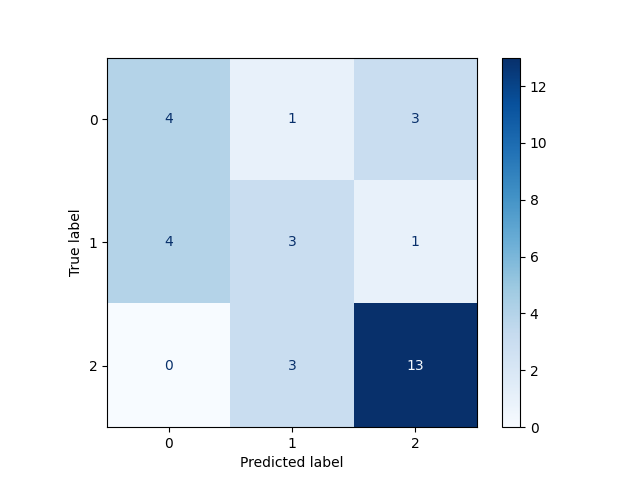


Accuracy
0.625


In [10]:
# メイン処理
subject = 'subject4'
data_dir = f'pump_split_modeling/train/{subject}'  # データが格納されているディレクトリのパスを指定

# 特徴量抽出
csvReader = EEGCSVreader(data_dir)
try:
    X, y = csvReader.transform(None)
    # yの3を2に変換
    # y[y==3] = 2
except ValueError as e:
    print(f"Error: {str(e)}")
    print("Please check your data directory and ensure all files have the correct format.")
    exit(1)


# クラスの分布を確認    
# trainにおよそ80ずつ，valにおよそ40ずつ入っている．
unique, counts = np.unique(y, return_counts=True)
print("\nClass distribution:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)


extractor = EEGFeatureExtractor()
X_train_features = extractor.extract(X_train, y_train)
X_test_features = extractor.apply(X_test)

# # 時間をかけてしっかり学習する
# gbm_params = {
#     'objective': 'multiclass',
#     'metric': 'multi_logloss',
#     'boosting_type': 'gbdt',
#     'verbose': -1,
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 4,
#     'lambda_l1': 4.0,
#     'num_estimators': 1000,
#     'learning_rate': 0.05,
# }

# # モデルの定義
# model = LGBMClassifier(random_state=42, **gbm_params)
# # 全トレーニングデータでモデルを訓練
# model.fit(X_train_features, y_train)
# # # ひどいランダムなデータならちゃんとaccuracyが0.25になる
# # model.fit([np.random.rand(288) for i in range(len(X_train_features))], y_train)
# # テストデータの予測
# y_pred = model.predict(X_test_features)

gbm_params_optuna = {
    'objective': 'multiclass',       # 多クラス分類用
    'metric': 'multi_logloss',       # マルチクラス分類の対数損失
    'num_class': 4,        # クラス数を指定
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': 42,
}

train_data = lgb.Dataset(np.array(X_train_features), label=np.array(y_train))
test_data = lgb.Dataset(np.array(X_test_features), label=np.array(y_test), reference=train_data)



model = lgb.train(gbm_params_optuna, 
                  train_data, 
                  valid_sets=[test_data], 
                  num_boost_round=1000)

y_pred = model.predict(X_test_features,num_iteration=model.best_iteration).argmax(axis=1)

# ここで，クラス3をクラス2に統合する
y_test[y_test==3] = 2 
y_pred[y_pred==3] = 2 

# 混同行列
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')
plt.show()

# テストデータでの評価
print("\nAccuracy")
print(np.mean(y_test == y_pred))


# # # 特徴量の重要度（オプション）
# feature_importance = model.feature_importances_
# importance_df = pd.DataFrame({'feature': extractor.feature_names, 'importance': feature_importance})
# importance_df = importance_df.sort_values('importance', ascending=False)
# print("\nTop important features:")
# print(importance_df.head(10))

100%|██████████| 160/160 [00:01<00:00, 123.92it/s]


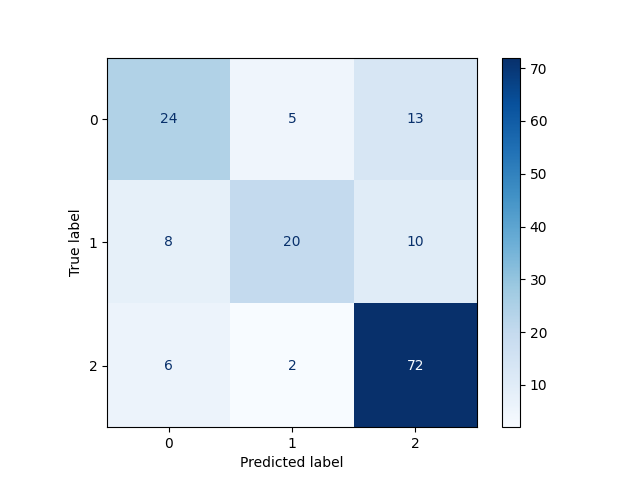


Accuracy
0.725


In [11]:
# validate
val_data_dir = f'pump_split_modeling/val/{subject}'  
csvReader = EEGCSVreader(val_data_dir)

try:
    X_val, y_val = csvReader.transform(None)
except ValueError as e:
    print(f"Error: {str(e)}")
    print("Please check your data directory and ensure all files have the correct format.")
    exit(1)


X_val_features = extractor.apply(X_val)

# テストデータの予測
y_val_pred = model.predict(X_val_features,num_iteration=model.best_iteration).argmax(axis=1)

# ここで，クラス3をクラス2に統合する
y_val[y_val==3] = 2
y_val_pred[y_val_pred==3] = 2

# 混同行列
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val))
disp.plot(cmap='Blues')
plt.show()

# テストデータでの評価
print("\nAccuracy")
print(np.mean(y_val == y_val_pred))


# val_accuracy = model.score(X_val_features, y_val)
# print(f"\nValidation accuracy: {val_accuracy:.4f}")

In [15]:
a = [0.7044,0.6164,0.5886,0.55625,0.7063]
b = [0.7107,0.5975,0.5886,0.575,0.74375]
c = [0.7421,0.6164,0.6139,0.6,0.7125]
with_band_power = [0.7170,0.5912,0.6266,0.6063,0.7313]

# one each
dist = [0.7107,0.6289,0.6076,0.5438,0.725]
fit = [0.6918,0.4780,0.5063,0.5313,0.5375]
ica = [0.69198,0.6415,0.6076,0.6,0.75]  # 0.6875 train test
band_power = [0.5472,0.5283,0.4810,0.475,0.6188]
csp = [0.5786,0.4591,0.5696,0.4813,0.5875]
corr = [0.5597,0.3711]
dtw = [0.6730,0.5786]

# one each optimized
dist_opt = [0.7296,0.6226,0.6433,0.5625,0.725]
ica_opt = [0.7107,0.6604,0.5860,0.5688,0.75]

print(np.mean(dist))


0.6432


### 提出用train

In [ ]:
# メイン処理
subject = 'subject4'
data_dir = f'pump_split_modeling/train/{subject}'  # データが格納されているディレクトリのパスを指定
val_data_dir = f'pump_split_modeling/val/{subject}'  # データが格納されているディレクトリのパスを指定

# ファイル読み出し
csvReader = EEGCSVreader(data_dir)
try:
    X, y = csvReader.transform(None)
    # yの3を2に変換
    # y[y==3] = 2
except ValueError as e:
    print(f"Error: {str(e)}")
    print("Please check your data directory and ensure all files have the correct format.")
    exit(1)

# valファイルの読み出し

csvReader = EEGCSVreader(val_data_dir)
try:
    X_val, y_val = csvReader.transform(None)
    # yの3を2に変換
    # y[y==3] = 2
except ValueError as e:
    print(f"Error: {str(e)}")
    print("Please check your data directory and ensure all files have the correct format.")
    exit(1)


X.extend(X_val)
y = np.concatenate([y, y_val])



# クラスの分布を確認    
# trainにおよそ80ずつ，valにおよそ40ずつ入っている．
unique, counts = np.unique(y, return_counts=True)
print("\nClass distribution:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")

# # トレーニングデータとテストデータに分割
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

final_extractor = EEGFeatureExtractor()
X_features = final_extractor.extract(X, y)
# X_test_features = final_extractor.apply(X_test)


# 時間をかけてしっかり学習する
gbm_params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'verbose': -1,
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.8,
    'bagging_freq': 4,
    'lambda_l1': 4.0,
    'num_estimators': 1000,
    'learning_rate': 0.05,
}


# モデルの定義
final_model = LGBMClassifier(random_state=42, **gbm_params)

# 全トレーニングデータでモデルを訓練
final_model.fit(X_features, y)
# # ひどいランダムなデータならちゃんとaccuracyが0.25になる
# final_model.fit([np.random.rand(288) for i in range(len(X_train_features))], y_train)

# # テストデータの予測
# y_pred = final_model.predict(X_test_features)

# # ここで，クラス3をクラス2に統合する
# y_test[y_test==3] = 2 
# y_pred[y_pred==3] = 2 

# # 混同行列
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
# disp.plot(cmap='Blues')
# plt.show()

# # テストデータでの評価
# print("\nAccuracy")
# print(np.mean(y_test == y_pred))


# # # 特徴量の重要度（オプション）
# feature_importance = final_model.feature_importances_
# importance_df = pd.DataFrame({'feature': final_extractor.feature_names, 'importance': feature_importance})
# importance_df = importance_df.sort_values('importance', ascending=False)
# print("\nTop important features:")
# print(importance_df.head(10))


### 提出ファイル作成

In [ ]:
data = read_mat(os.path.join('.', 'test', f'{subject}.mat'))
data = data['data']
print(data.shape)
# assert data.shape[0] == 160
assert data.shape[1] == 72
assert data.shape[2] == 250


X_final = []
for i in range(data.shape[0]):
    trick_data = data[i,:,:]
    trick_df = pd.DataFrame(trick_data.T, 
                            columns=final_extractor.channels,
                            index=range(1,251))
    X_final.append(trick_df)

# 特徴量抽出
X_final_features = final_extractor.apply(X_final)

# テストデータの予測
y_final_pred = final_model.predict(X_final_features)

# ここで，クラス3をクラス2に統合する
y_final_pred[y_final_pred==3] = 2

# 予測ラベルをトリック名に
event_dict = {
    0: str(csvReader.label_encoder.classes_[0]),
    1: str(csvReader.label_encoder.classes_[1]),
    2: str(csvReader.label_encoder.classes_[2])
}

print(event_dict)

y_final_pred = [event_dict[i] for i in y_final_pred]

# 提出用ファイルの作成

submission = pd.DataFrame({'id': [f'{subject}_{i:03d}' for i in range(len(X_final))], 'label': y_final_pred})
print(submission.head())
submission.to_csv(f'submission_{subject}_aaa.csv', index=False)


    

In [31]:
# 全てのsubmissionファイルを結合

dfs = []
for i in range(5):
    subject = f'subject{i}'
    df = pd.read_csv(f'submission_{subject}_aaa.csv')
    dfs.append(df)


submission = pd.concat(dfs, ignore_index=True)
submission.to_csv('submission_1014.csv', index=False, header=False)

In [ ]:
# validate
val_data_dir = f'pump_split_modeling/val/{subject}'  
csvReader = EEGCSVreader(val_data_dir)

try:
    X_val, y_val = csvReader.transform(None)
except ValueError as e:
    print(f"Error: {str(e)}")
    print("Please check your data directory and ensure all files have the correct format.")
    exit(1)

X_val_features = extractor.apply(X_val)

# テストデータの予測
y_val_pred = model.predict(X_val_features)

# ここで，クラス3をクラス2に統合する
y_val[y_val==3] = 2
y_val_pred[y_val_pred==3] = 2

# 混同行列
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val))
disp.plot(cmap='Blues')
plt.show()

# テストデータでの評価
print("\nAccuracy")
print(np.mean(y_val == y_val_pred))

In [ ]:
def output_pred(src_dir, root_dir, subject_ids, models, seq_length, transform, device):
    predictions = {}
    for subject_id in subject_ids:
        train_dir =os.path.join(root_dir, subject_id)
        class_names = os.listdir(train_dir)
        class_names.sort()
        data = read_mat(os.path.join(src_dir, 'test', '{}.mat'.format(subject_id)))
        for i, ts in enumerate(data['data']): # type: ignore
            tensor = torch.from_numpy(transform(standardization(ts, axis=1), is_train=False, seq_length=seq_length)).unsqueeze(0).to(device) # type: ignore
            pred = models[subject_id](tensor)
            _, output_index = pred.max(1)
            pred = output_index.squeeze(0).cpu().detach().numpy()
            predictions['{}_{:03d}'.format(subject_id, i)]=class_names[pred]
    result = pd.Series(predictions)

    return result

src_dir = '.'
root_dir = os.path.join('test_modeling', 'train')
subject_ids = ['subject0', 'subject1', 'subject2', 'subject3', 'subject4']
seq_length = 250
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
result = output_pred(src_dir, root_dir, subject_ids, models, seq_length, transform, device)
result.to_csv('submit.csv', header=False)

## データ生成器

In [15]:
class SeqDataset(Dataset):  # PytorchのDatasetクラスを継承
    def __init__(self, root, seq_length, is_train, transform=None):
        self.transform = transform
        self.seqs = []
        self.seq_labels = []
        self.class_names = os.listdir(root)
        self.class_names.sort()
        self.numof_classes = len(self.class_names)
        self.seq_length = seq_length
        self.is_train = is_train    # トレーニングモードかどうか

        for (i,x) in enumerate(self.class_names):
            temp = glob.glob(os.path.join(root, x, '*'))
            temp.sort()
            self.seq_labels.extend([i]*len(temp))
            for t in temp:
                df = pd.read_csv(t, header=None)
                tensor = preprocess(df)
                self.seqs.append(tensor)

    def __getitem__(self, index):   # 呼び出すごとにノイズを加えるので、毎回異なるデータが得られる
        seq = self.seqs[index]
        if self.transform is not None:
            seq = self.transform(seq, is_train=self.is_train, seq_length=self.seq_length)
        return {'seq':seq, 'label':self.seq_labels[index]}


    def __len__(self):
        return len(self.seqs)


def preprocess(df: pd.DataFrame)->np.ndarray:
    # transpose
    mat = df.T.values

    # standerization
    mat = standardization(mat, axis=1)

    return mat


def standardization(a, axis=None, ddof=0):
    a_mean = a.mean(axis=axis, keepdims=True)
    a_std = a.std(axis=axis, keepdims=True, ddof=ddof)
    a_std[np.where(a_std==0)] = 1

    return (a - a_mean) / a_std


def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    data_noisy = data + noise
    return data_noisy.astype(np.float32)


def time_shift(data, shift):    # 時間方向にシフト，使ってない
    data_shifted = np.roll(data, shift)
    return data_shifted


def transform(array, is_train, seq_length):
    if is_train:
        _, n = array.shape
        s = random.randint(0, n-seq_length)
        ts = array[:,s:s+seq_length]
        ts = add_noise(ts).astype(np.float32)
        if random.randint(0,1):
            ts_r = ts[:,::-1].copy()
            return ts_r
        return ts
    else:
        ts = array[:,:seq_length].astype(np.float32)    # 学習時以外は通常の0.5sのデータを返す
        return ts

batch_size=10
train_dir = os.path.join('test_modeling', 'train', subject_id)
dataset = SeqDataset(root=train_dir, seq_length=250, is_train=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True) # type: ignore

In [ ]:
print(dataset.class_names)
for i, mini_batch in enumerate(data_loader):
    print(mini_batch['seq'].shape, mini_batch['label'])

## モデルの構築

In [37]:
class Net1DBN(torch.nn.Module):
    def __init__(self, num_channels, num_classes):
        super(Net1DBN, self).__init__()
        self.conv1 = torch.nn.Conv1d(num_channels, 128, kernel_size=3, stride=1)
        self.conv2 = torch.nn.Conv1d(128, 128, kernel_size=3, stride=1)
        self.conv3 = torch.nn.Conv1d(128, 128, kernel_size=3, stride=1)
        self.conv4 = torch.nn.Conv1d(128, 128, kernel_size=3, stride=1)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.bn3 = torch.nn.BatchNorm1d(128)
        self.bn4 = torch.nn.BatchNorm1d(128)
        self.maxpool = torch.nn.MaxPool1d(kernel_size=3, stride=2)  # プーリングで3次元目方向を半分にする
        self.gap = torch.nn.AdaptiveAvgPool1d(1)    # 全体の平均を取る（Adaptive : 指定した出力サイズに合わせて適応的にプーリング）
        self.fc = torch.nn.Linear(128, num_classes)


    def forward(self, x):
        # 入力xのサイズは(batch_size, num_channels(72), seq_length(250))
        x = self.conv1(x)   # 重みサイズは(128, 72, 3), 72x3の畳み込みを時間方向に進める，そのフィルタが128個
        # xのサイズは(batch_size, 128, 248(250-3+1))
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.maxpool(x) # プーリングで時系列方向が半分になる(batch,128,123) 

        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.maxpool(x) # プーリングで時系列方向が半分になる(batch,128,60)
 
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.maxpool(x) # プーリングで時系列方向が半分になる(batch,128,28) 

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.gap(x) # 時間方向に対して全体の平均を取る(batch,128,1)
        x = x.squeeze(2) # 3次元目を削除して(batch,128)

        x = self.fc(x) # (batch, num_classes)

        return x

In [ ]:
num_channels = 72  # チャンネル数
num_classes = 3    # 判別するトリックの種別数
model = Net1DBN(num_channels, num_classes)
in_data = torch.randn(8, num_channels, 250)
out_data = model(in_data)   # 入力は基本，(batch_size, num_channels, seq_length)
print(out_data)

## モデルの学習

In [41]:
def train(log_interval, model, device, train_loader, optimizer, epoch, iteration):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    for sample_batched in train_loader:
        data, target = sample_batched['seq'].to(device), sample_batched['label'].to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.max(1, keepdim=True)[1]
        correct = pred.eq(target.view_as(pred)).sum().item()    # 予測が正しい数
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        iteration += 1
        if iteration % log_interval == 0:
            sys.stdout.write('\repoch:{0:>3} iteration:{1:>6} train_loss: {2:.6f} train_accracy: {3:5.2f}%'.format(
                            epoch, iteration, loss.item(), 100.*correct/float(len(sample_batched['label']))))
            sys.stdout.flush()
    return iteration


def val(model, device, test_loader):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss(reduction='sum')
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for sample_batched in test_loader:
            data, target = sample_batched['seq'].to(device), sample_batched['label'].to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= float(len(test_loader.dataset))
    correct /= float(len(test_loader.dataset))
    print('\n  Validation: Accuracy: {0:.2f}%  test_loss: {1:.6f}'.format(100. * correct, test_loss))
    return test_loss, 100. * correct


def evaluate(model, device, test_loader):
    preds = []
    trues = []
    model.eval()
    with torch.no_grad():
        for sample_batched in test_loader:
            data, target = sample_batched['seq'].to(device), sample_batched['label'].to(device)
            output = model(data)
            pred = [test_loader.dataset.class_names[i] for i in list(output.max(1)[1].cpu().detach().numpy())]
            preds += pred
            true = [test_loader.dataset.class_names[i] for i in list(target.cpu().detach().numpy())]
            trues += true
    labels = test_loader.dataset.class_names
    cm = confusion_matrix(trues, preds, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()
    cr = classification_report(trues, preds, target_names=labels)
    print(cr)
    correct = 0
    for pred, true in zip(preds, trues):
        if pred == true:
            correct += 1
    df = pd.DataFrame({'pred': preds, 'true': trues})

    return correct/len(trues), df


def train_evaluate(train_dir, val_dir, log_interval, num_epoches, seq_length, transform=None, num_channels=72, num_classes = 3):
    model = Net1DBN(num_channels=num_channels, num_classes=num_classes)

    # cuda or mps or cpu
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('Using GPU')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')    # apple metal performance shader
        print('Using MPS')
    else:
        device = torch.device('cpu')
        print('Using CPU')
    model.to(device)

    train_loader = torch.utils.data.DataLoader(SeqDataset(root=train_dir, seq_length=seq_length, is_train=True, transform=transform), batch_size=20, shuffle=True) # type: ignore
    optimizer = torch.optim.Adam(model.parameters())
    val_loader = torch.utils.data.DataLoader(SeqDataset(root=val_dir, seq_length=seq_length, is_train=False, transform=transform), batch_size=20, shuffle=False) # type: ignore
    iteration = 0
    for epoch in range(1, 1+num_epoches):
        iteration = train(log_interval, model, device, train_loader, optimizer, epoch, iteration)
        if epoch%10==0:
            test_loss, test_acc = val(model, device, val_loader)
    acc, df = evaluate(model, device, val_loader)
    print(acc)
    return model

In [ ]:
log_interval = 5000
num_epoches = 10 
seq_length = 250
models = {}
for subject_id in subject_ids:
    train_dir = os.path.join('test_modeling', 'train', subject_id)
    val_dir = os.path.join('test_modeling', 'val', subject_id)
    model = train_evaluate(train_dir, val_dir, log_interval, num_epoches, seq_length, transform)
    models[subject_id] = model

In [ ]:
a = np.array([0.7044,0.6164,0.5886,0.55625,0.7063])
print(a.shape)
a = a.reshape(-1,1)
print(a.shape)